# Recurrent neighbors from retrospective cohorts
We applied matchmaking to the mCRPC and metastatic melanoma retrospective cohorts. In this notebook, we look at the results; specifically, which cell lines are recurrent nearest neighbor and what therapies are these cell lines sensitive to. 

Outputs here differ slightly from paper due to redaction of germline calls for public repository.

In [1]:
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../common/')
import settings
settings.set_arial_as_font()

from settings import Colors
tableau10 = Colors.tableau10

%matplotlib inline

In [2]:
robinson_handles = glob.glob('../retrospective-cohorts/2015-Robinson/data/almanac/*/*.matchmaker.txt')
vanallen_handles = glob.glob('../retrospective-cohorts/2015-VanAllen/data/almanac/*/*.matchmaker.txt')

summary = pd.read_csv('formatted/cell-lines.summary.txt', sep='\t')
zscores = pd.read_csv('formatted/sanger.gdsc.txt', sep='\t')

broad_to_ccle_map = summary.set_index('broad')['ccle_name'].dropna().to_dict()
sanger_to_ccle_map = summary.set_index('sanger')['ccle_name'].dropna().to_dict()

zscores['ccle_name'] = zscores['model_id'].replace(sanger_to_ccle_map)

## Functions

In [3]:
def plot_individual_bar(dataframe, title, color, filename, size_x=7.5, size_y=7.5):
    fig = plt.figure(constrained_layout=True, figsize=(size_x, size_y))
    ax = plt.subplot()
    remove_spines(ax)
    
    p1 = dataframe.value_counts().plot(kind='bar', color=color)
    plt.title(title, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    
    plt.xlim([-1, 10.5])
    
    for suffix in ['svg', 'png']:
        outname = f'../../figures/{filename}.{suffix}'
        plt.savefig(outname, format=suffix)
    
    return fig

def plot_horizontal_bar_pair(dataframe1, title1, color1, dataframe2, title2, color2, filename):
    fig = plt.figure(constrained_layout=True, figsize=(15, 7.5))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    
    ax0 = fig.add_subplot(spec[0, 0])
    p1 = dataframe1.value_counts().plot(kind='bar', color=color1)
    plt.title(title1, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    ax1 = fig.add_subplot(spec[0, 1])
    p1 = dataframe2.value_counts().plot(kind='bar', color=color2)
    plt.title(title2, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    for ax in [ax0, ax1]:
        remove_spines(ax)
        
    for suffix in ['svg', 'png']:
        outname = f'../../figures/{filename}.{suffix}'
        plt.savefig(outname, format=suffix)
    
    return fig

def plot_vertical_bar_pair(dataframe1, title1, color1, dataframe2, title2, color2, filename):
    fig = plt.figure(constrained_layout=True, figsize=(7.5, 10))
    spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    
    ax0 = fig.add_subplot(spec[0, 0])
    p1 = dataframe1.value_counts().plot(kind='bar', color=color1)
    plt.title(title1, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    ax1 = fig.add_subplot(spec[1, 0])
    p1 = dataframe2.value_counts().plot(kind='bar', color=color2)
    plt.title(title2, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    for ax in [ax0, ax1]:
        remove_spines(ax)
        
    for suffix in ['svg', 'png']:
        outname = f'../../figures/{filename}.{suffix}'
        plt.savefig(outname, format=suffix)
    
    return fig
    
def remove_spines(axis):
    axis.spines["top"].set_visible(False)    
    axis.spines["bottom"].set_visible(False)    
    axis.spines["right"].set_visible(False)    
    axis.spines["left"].set_visible(False)

## Metastatic castration resistant prostate cancer

VCAP_PROSTATE                    25
A498_KIDNEY                      10
SNB75_CENTRAL_NERVOUS_SYSTEM      8
U118MG_CENTRAL_NERVOUS_SYSTEM     6
HS578T_BREAST                     4
                                 ..
NUGC3_STOMACH                     1
TGBC11TKB_STOMACH                 1
CORL279_LUNG                      1
JHH4_LIVER                        1
J82_URINARY_TRACT                 1
Length: 73, dtype: int64

       DATASET   model_id    therapy_name   ln_ic50       AUC   z_score  \
111828   GDSC1  SIDM01077      Selisistat  3.349903  0.904029 -3.144959   
99008    GDSC1  SIDM01077         SB52334  0.598206  0.559422 -2.837785   
190919   GDSC1  SIDM01077         UNC0642 -0.065823  0.922648 -2.714331   
139269   GDSC1  SIDM01077  Trichostatin A -4.415568  0.249313 -2.574632   
311185   GDSC2  SIDM01077        Acetalax -0.070278  0.497881 -2.233568   
271588   GDSC2  SIDM01077      Linsitinib  0.927585  0.775529 -2.193012   
148379   GDSC1  SIDM01077            BAM7  3.251095  

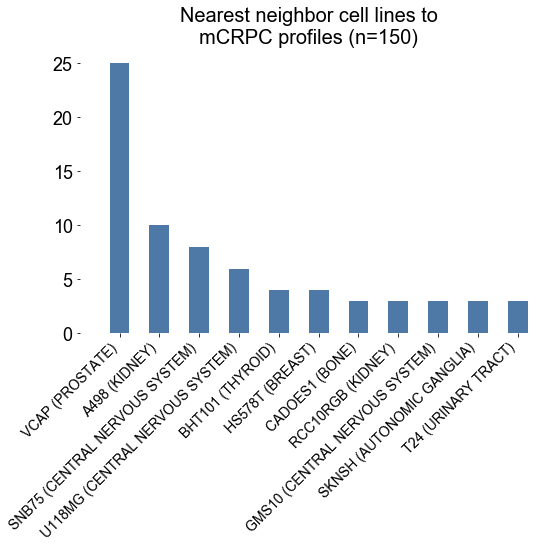

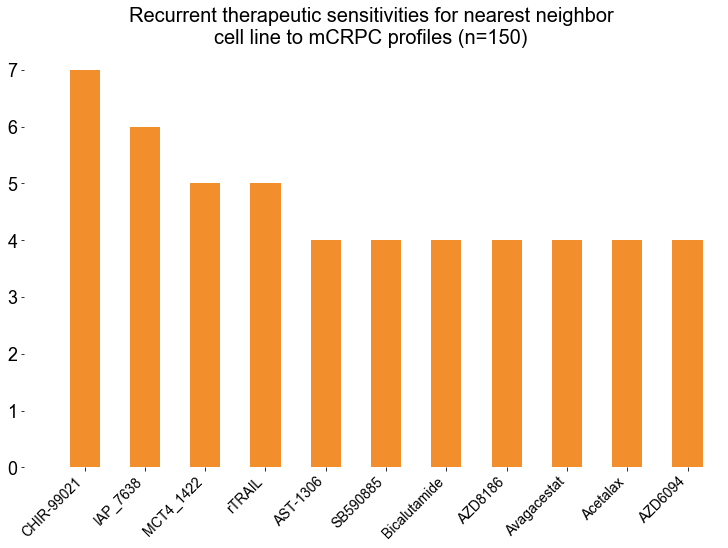

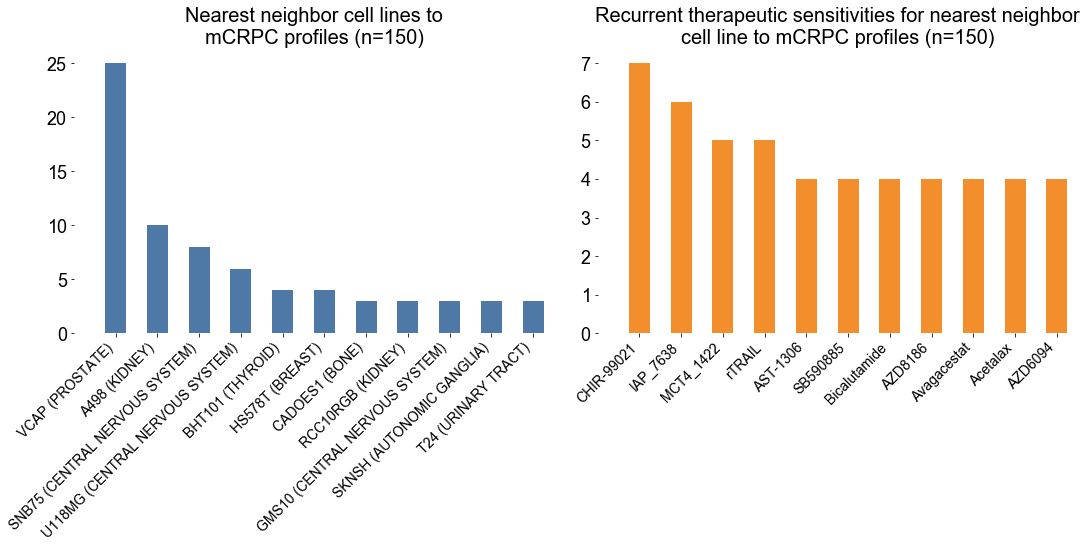

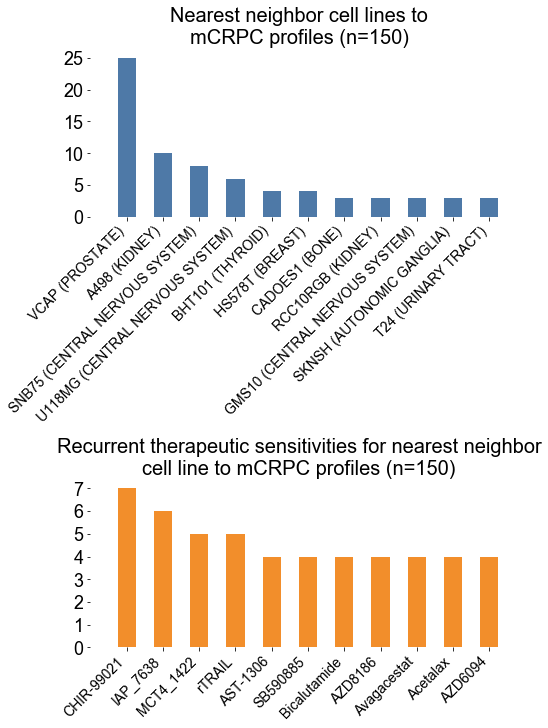

In [4]:
title1 = 'Nearest neighbor cell lines to\nmCRPC profiles (n=150)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to mCRPC profiles (n=150)'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in robinson_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.unique().tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts())
print('')

print(zscores[zscores['ccle_name'].eq('VCAP_PROSTATE')].sort_values('z_score', ascending=True).head(10))
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'

neighbors = plot_individual_bar(first_neighbors, title1, color=tableau10['blue'], 
                                filename='matchmaking.mCRPC.nearest-neighbors')
therapies = plot_individual_bar(first_neighbor_therapies, title2, color=tableau10['orange'], 
                                filename='matchmaking.mCRPC.nearest-neighbors-therapies', size_x=10)
horizontal = plot_horizontal_bar_pair(first_neighbors, title1, tableau10['blue'],
                                      first_neighbor_therapies, title2, tableau10['orange'],
                                      'matchmaking.mCRPC.nearest-neighbors.horizontal')
vertical = plot_vertical_bar_pair(first_neighbors, title1, tableau10['blue'],
                                  first_neighbor_therapies, title2, tableau10['orange'],
                                  'matchmaking.mCRPC.nearest-neighbors.vertical')

## Metastatic melanoma

SKHEP1_LIVER                     11
A375_SKIN                         6
GCT_SOFT_TISSUE                   5
KALS1_CENTRAL_NERVOUS_SYSTEM      3
CAOV4_OVARY                       3
                                 ..
IGROV1_OVARY                      1
COLO205_LARGE_INTESTINE           1
SKNDZ_AUTONOMIC_GANGLIA           1
NCIH1092_LUNG                     1
U118MG_CENTRAL_NERVOUS_SYSTEM     1
Length: 72, dtype: int64

SB590885             11
Refametinib          10
RAF_9304              8
Dabrafenib            7
CI-1040               6
(5Z)-7-Oxozeaenol     5
Ulixertinib           5
ERK_6604              5
TANK_1366             5
PLX-4720              5
Name: therapy_name, dtype: int64



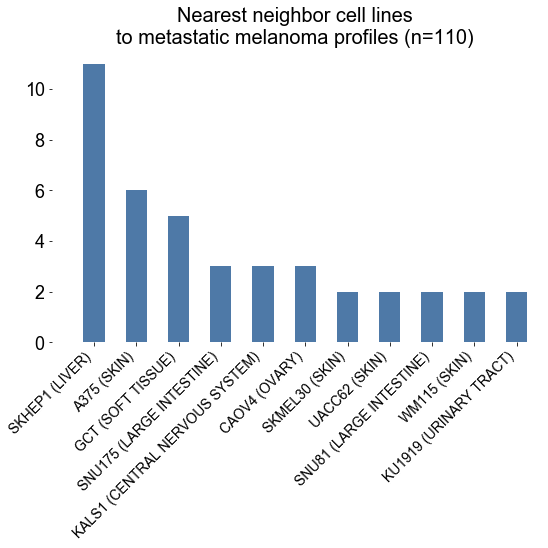

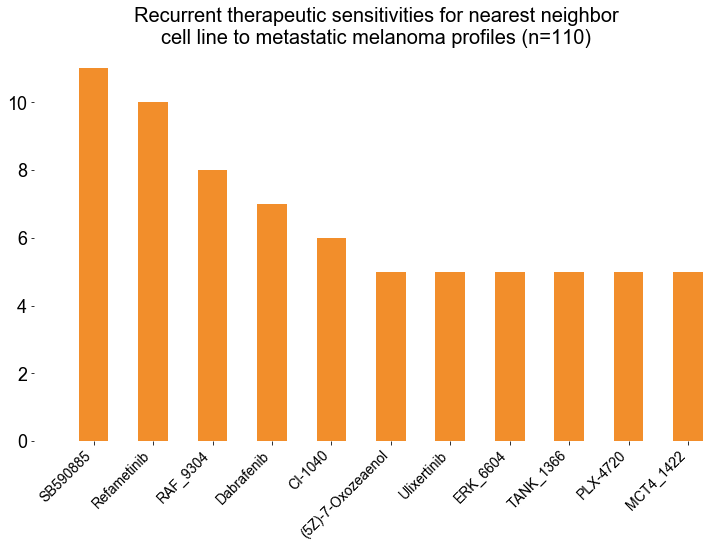

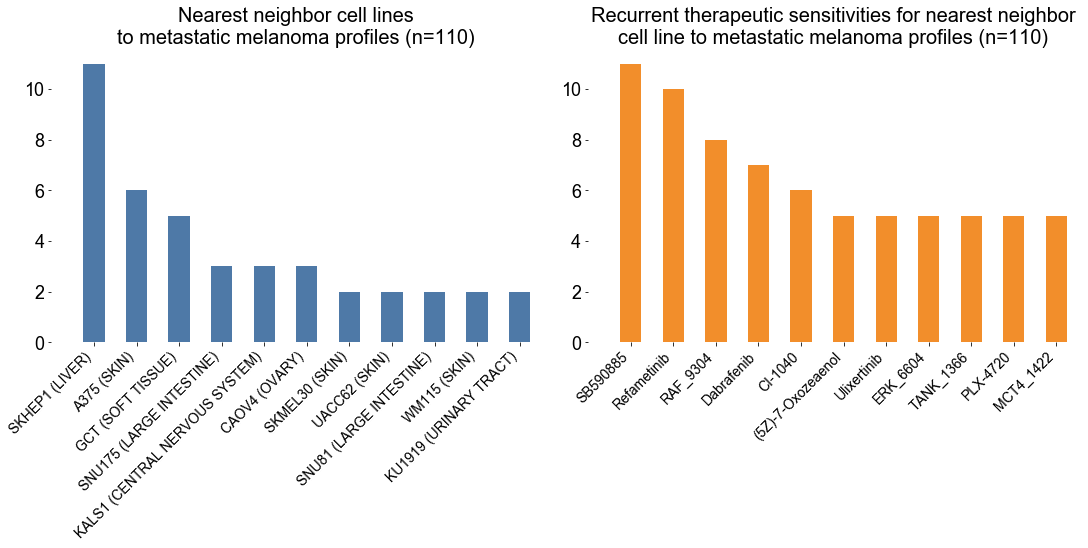

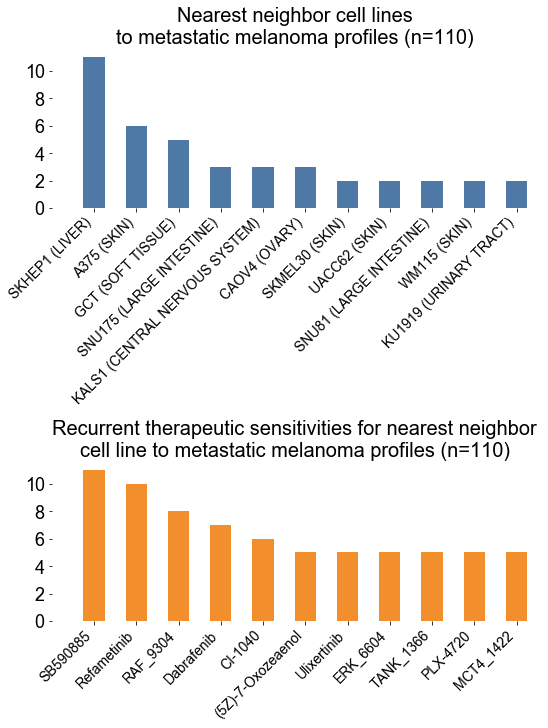

In [5]:
title1 = 'Nearest neighbor cell lines\nto metastatic melanoma profiles (n=110)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to metastatic melanoma profiles (n=110)'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in vanallen_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.unique().tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts())
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'

neighbors = plot_individual_bar(first_neighbors, title1, color=tableau10['blue'], 
                                filename='matchmaking.metastatic-melanoma.nearest-neighbors')
therapies = plot_individual_bar(first_neighbor_therapies, title2, color=tableau10['orange'], 
                                filename='matchmaking.metastatic-melanoma.nearest-neighbors-therapies', size_x=10)
horizontal = plot_horizontal_bar_pair(first_neighbors, title1, tableau10['blue'],
                                      first_neighbor_therapies, title2, tableau10['orange'],
                                      'matchmaking.metastatic-melanoma.nearest-neighbors.horizontal')
vertical = plot_vertical_bar_pair(first_neighbors, title1, tableau10['blue'],
                                  first_neighbor_therapies, title2, tableau10['orange'],
                                  'matchmaking.metastatic-melanoma.nearest-neighbors.vertical')

## Metastatic melanoma w/o BRAF p.V600E patients

In [6]:
retrospective = pd.read_csv('../retrospective-cohorts/retrospective.actionability.txt', sep='\t')
retrospective

,patient_id,feature_string,almanac_bin,phial_bin,sum,cohort,sensitive_predictive_implication,resistance_predictive_implication,prognostic_predictive_implication,clinvar,feature_type,feature_str_simple
0,MEL-IPI_Pat04,CDKN2A/B.Deletion,Putatively Actionable,Investigate Actionability,2,MEL,Preclinical,NaN,NaN,NaN,Somatic copy number,CDKN2A/B Del
1,MEL-IPI_Pat07,CDKN2A/B.Deletion,Putatively Actionable,NaN,1,MEL,Preclinical,NaN,NaN,NaN,Somatic copy number,CDKN2A/B Del
2,MEL-IPI_Pat100,CDKN2A/B.Deletion,Putatively Actionable,Investigate Actionability,2,MEL,Preclinical,NaN,NaN,NaN,Somatic copy number,CDKN2A/B Del
3,MEL-IPI_Pat106,CDKN2A/B.Deletion,Putatively Actionable,Investigate Actionability,2,MEL,Preclinical,NaN,NaN,NaN,Somatic copy number,CDKN2A/B Del
4,MEL-IPI_Pat119,CDKN2A/B.Deletion,Putatively Actionable,Investigate Actionability,2,MEL,Preclinical,NaN,NaN,NaN,Somatic copy number,CDKN2A/B Del
...,...,...,...,...,...,...,...,...,...,...,...,...
3667,TP_2064,COSMIC Signature 15,Biologically Relevant,NaN,1,SU2C,NaN,NaN,NaN,NaN,Mutational signature,COSMIC Signature 15
3668,TP_2064,COSMIC Signature 6,Biologically Relevant,NaN,1,SU2C,NaN,NaN,NaN,NaN,Mutational signature,COSMIC Signature 6
3669,TP_2064,MPL.p.A134T,Investigate Actionability,Biologically Relevant,2,SU2C,Preclinical,NaN,NaN,NaN,Somatic variant,MPL
3670,TP_2064,TP53.p.H179R,Investigate Actionability,Investigate Actionability,2,SU2C,NaN,Clinical evidence,Clinical evidence,NaN,Somatic variant,TP53


In [7]:
all_melanoma = pd.Index(retrospective[retrospective['cohort'].eq('MEL')]['patient_id'].drop_duplicates())
melanoma_v600e = pd.Index(
    retrospective[retrospective['cohort'].eq('MEL') & retrospective['feature_string'].eq('BRAF.p.V600E')]
    ['patient_id']
    .drop_duplicates()
)
melanoma_nras = pd.Index(
    retrospective[retrospective['cohort'].eq('MEL') & retrospective['feature_string'].str.contains('NRAS')]
    ['patient_id']
    .drop_duplicates()
)
melanoma_non_v600e = all_melanoma.difference(melanoma_v600e).intersection(melanoma_nras)
print(len(melanoma_non_v600e))
melanoma_non_v600e

use_samples = melanoma_non_v600e

24


SKMEL30_SKIN                    2
CAOV4_OVARY                     2
SKMEL2_SKIN                     2
TE10_OESOPHAGUS                 1
MELHO_SKIN                      1
HS683_CENTRAL_NERVOUS_SYSTEM    1
SKNDZ_AUTONOMIC_GANGLIA         1
MG63_BONE                       1
KU1919_URINARY_TRACT            1
CCK81_LARGE_INTESTINE           1
NCIH1092_LUNG                   1
TT2609C02_THYROID               1
MESSA_SOFT_TISSUE               1
GCT_SOFT_TISSUE                 1
NCIH196_LUNG                    1
SKHEP1_LIVER                    1
SNU175_LARGE_INTESTINE          1
SH4_SKIN                        1
KALS1_CENTRAL_NERVOUS_SYSTEM    1
LXF289_LUNG                     1
LS513_LARGE_INTESTINE           1
dtype: int64

RAF_9304       3
Ulixertinib    3
XMD11-85h      3
SB590885       3
TANK_1366      3
Refametinib    3
PFI-3          2
Amuvatinib     2
VX-11e         2
MCT4_1422      2
Name: therapy_name, dtype: int64



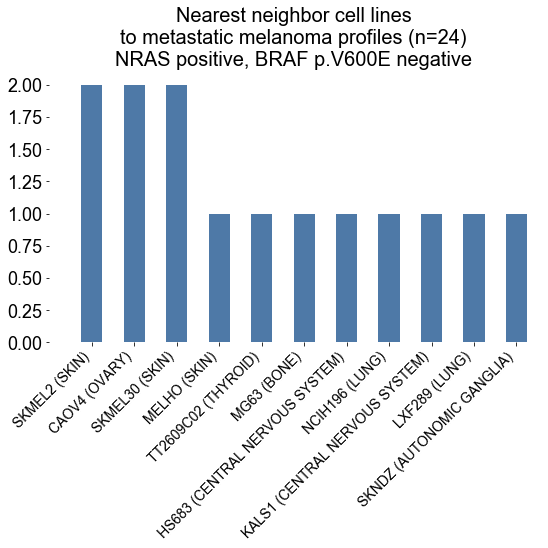

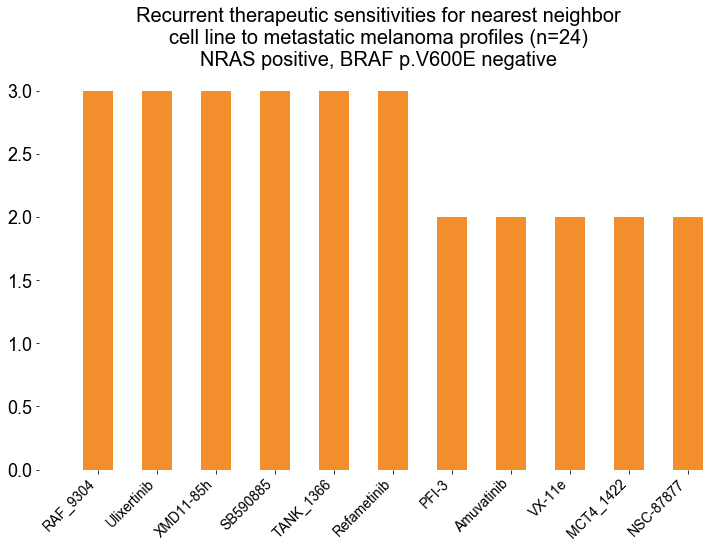

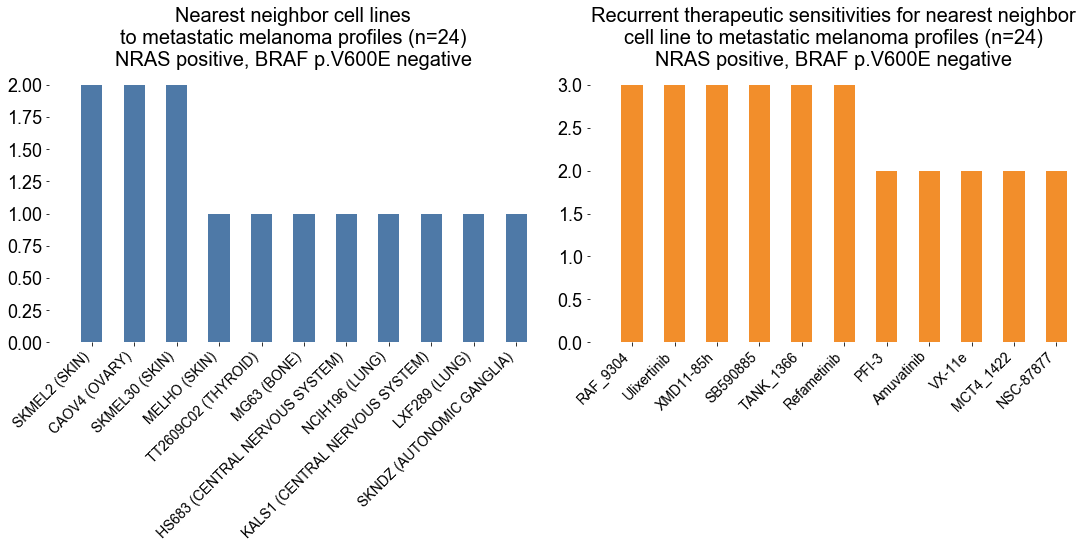

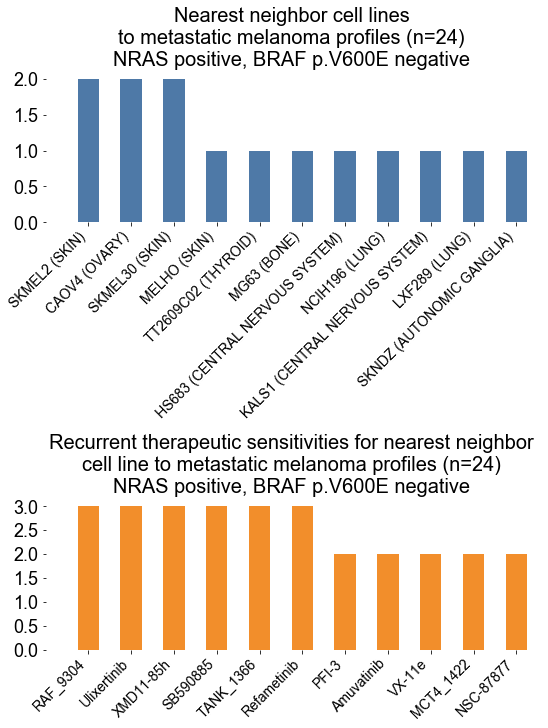

In [8]:
title1 = f'Nearest neighbor cell lines\nto metastatic melanoma profiles (n={len(use_samples)})\nNRAS positive, BRAF p.V600E negative'
title2 = f'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to metastatic melanoma profiles (n={len(use_samples)})\nNRAS positive, BRAF p.V600E negative'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in vanallen_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)
df = df[df['case'].isin(use_samples)]

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.unique().tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts())
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'

neighbors = plot_individual_bar(first_neighbors, title1, color=tableau10['blue'], 
                                filename='matchmaking.metastatic-melanoma.nras.nearest-neighbors')
therapies = plot_individual_bar(first_neighbor_therapies, title2, color=tableau10['orange'], 
                                filename='matchmaking.metastatic-melanoma.nras.nearest-neighbors-therapies', size_x=10)
horizontal = plot_horizontal_bar_pair(first_neighbors, title1, tableau10['blue'],
                                      first_neighbor_therapies, title2, tableau10['orange'],
                                      'matchmaking.metastatic-melanoma.nras.nearest-neighbors.horizontal')
vertical = plot_vertical_bar_pair(first_neighbors, title1, tableau10['blue'],
                                  first_neighbor_therapies, title2, tableau10['orange'],
                                  'matchmaking.metastatic-melanoma.nras.nearest-neighbors.vertical')

In [9]:
retrospective[retrospective['patient_id'].isin(use_samples) & retrospective['feature_string'].eq('BRAF.p.V600E')]

,patient_id,feature_string,almanac_bin,phial_bin,sum,cohort,sensitive_predictive_implication,resistance_predictive_implication,prognostic_predictive_implication,clinvar,feature_type,feature_str_simple


In [11]:
len(use_samples)

24